# Skip-gram word2vec

In this notebook, I learn how to use TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, I will learn about embedding words for use in natural language processing. This will come in handy when dealing with things like translations. This is a part of the Udacity "Foundations in Deep Learning Nanodegree"

## Readings

Here are the resources I used to build this notebook. 

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with language and words, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module my instructor wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here my instructor is creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.



> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if p_drop[word] < random.random()]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # Your code here
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)
    

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window.This is a generator function by the way, helps save memory.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From Chris McCormick's blog, we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. This weight matrix is usually called the embedding matrix or embedding look-up table. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name = 'inputs') 
    labels = tf.placeholder(tf.int32, [None, None], name = 'labels')

## Embedding



The embedding matrix has a size of the number of words by the number of neurons in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using one-hot encoded vectors for our inputs. When you do the matrix multiplication of the one-hot vector with the embedding matrix, you end up selecting only one row out of the entire matrix:

![one-hot matrix multiplication](assets/matrix_mult_w_one_hot.png)

You don't actually need to do the matrix multiplication, you just need to select the row in the embedding matrix that corresponds to the input word. Then, the embedding matrix becomes a lookup table, you're looking up a vector the size of the hidden layer that represents the input word.

<img src="assets/word2vec_weight_matrix_lookup_table.png" width=500>


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform). This [TensorFlow tutorial](https://www.tensorflow.org/tutorials/word2vec) will help if you get stuck.

In [10]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [14]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6383 0.5012 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6168 0.5025 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.5508 0.5238 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5649 0.5603 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5125 0.4718 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5299 0.5121 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5400 0.5104 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5496 0.5384 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4913 0.4547 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4651 0.4794 sec/batch
Nearest to been: mouth, classified, pesach, rudimentary, americano, delphinidae, covered, nineteenth,
Nearest to after: stram, inflammable, poetics, sarah, anthropocentric, camulodunum, dinosaurs, anfa,
Nearest to however: jts, iberville, sums, sexes, gravity, nagasaki, roadster, leiter,
Nearest to

Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6577 0.4276 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6659 0.4238 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.5727 0.4255 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.6125 0.4278 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.6257 8.1465 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.6381 0.4252 sec/batch
Epoch 2/10 Iteration: 4700 Avg. Training loss: 4.5909 0.3342 sec/batch
Epoch 2/10 Iteration: 4800 Avg. Training loss: 4.5524 0.4953 sec/batch
Epoch 2/10 Iteration: 4900 Avg. Training loss: 4.4974 0.5575 sec/batch
Epoch 2/10 Iteration: 5000 Avg. Training loss: 4.4998 0.5872 sec/batch
Nearest to been: mouth, progresses, rudimentary, americano, meditate, nanometers, delphinidae, pesach,
Nearest to after: stench, della, inflammable, tinker, shipment, curfew, lifeless, stram,
Nearest to however: would, sexes, sums, counterexample, bustling, iberville, gravity, prenatal,
Ne

Epoch 2/10 Iteration: 8100 Avg. Training loss: 4.3233 0.5049 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 4.2638 0.4986 sec/batch
Epoch 2/10 Iteration: 8300 Avg. Training loss: 4.3712 0.4954 sec/batch
Epoch 2/10 Iteration: 8400 Avg. Training loss: 4.3730 0.4949 sec/batch
Epoch 2/10 Iteration: 8500 Avg. Training loss: 4.3732 0.5168 sec/batch
Epoch 2/10 Iteration: 8600 Avg. Training loss: 4.2734 0.4976 sec/batch
Epoch 2/10 Iteration: 8700 Avg. Training loss: 4.2916 0.4934 sec/batch
Epoch 2/10 Iteration: 8800 Avg. Training loss: 4.3329 0.4986 sec/batch
Epoch 2/10 Iteration: 8900 Avg. Training loss: 4.1887 0.4956 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 4.2857 0.4939 sec/batch
Nearest to been: progresses, mouth, rudimentary, meditate, americano, herzegovina, for, microprogramming,
Nearest to after: stench, tried, soon, brutally, stram, inflammable, confidant, fall,
Nearest to however: would, eases, sexes, jts, sums, counterexample, syrup, prenatal,
Nearest to we

Epoch 3/10 Iteration: 12100 Avg. Training loss: 4.2092 0.4308 sec/batch
Epoch 3/10 Iteration: 12200 Avg. Training loss: 4.1813 0.4292 sec/batch
Epoch 3/10 Iteration: 12300 Avg. Training loss: 4.1860 0.4250 sec/batch
Epoch 3/10 Iteration: 12400 Avg. Training loss: 4.1843 0.4260 sec/batch
Epoch 3/10 Iteration: 12500 Avg. Training loss: 4.1172 0.4282 sec/batch
Epoch 3/10 Iteration: 12600 Avg. Training loss: 4.1387 0.4219 sec/batch
Epoch 3/10 Iteration: 12700 Avg. Training loss: 4.1821 0.4265 sec/batch
Epoch 3/10 Iteration: 12800 Avg. Training loss: 4.1149 0.4294 sec/batch
Epoch 3/10 Iteration: 12900 Avg. Training loss: 4.1688 0.4271 sec/batch
Epoch 3/10 Iteration: 13000 Avg. Training loss: 4.1802 0.4277 sec/batch
Nearest to been: for, meditate, herzegovina, progresses, by, guilds, rudimentary, microprogramming,
Nearest to after: fall, uncle, stench, tried, stram, inflammable, babes, banna,
Nearest to however: would, terribly, eases, sums, who, humiliation, fellow, sisak,
Nearest to were: 

Epoch 4/10 Iteration: 16100 Avg. Training loss: 4.0613 0.4314 sec/batch
Epoch 4/10 Iteration: 16200 Avg. Training loss: 4.0726 0.4269 sec/batch
Epoch 4/10 Iteration: 16300 Avg. Training loss: 4.0770 0.4258 sec/batch
Epoch 4/10 Iteration: 16400 Avg. Training loss: 4.0330 0.4235 sec/batch
Epoch 4/10 Iteration: 16500 Avg. Training loss: 4.0468 0.4272 sec/batch
Epoch 4/10 Iteration: 16600 Avg. Training loss: 4.0642 0.4272 sec/batch
Epoch 4/10 Iteration: 16700 Avg. Training loss: 4.0737 0.4332 sec/batch
Epoch 4/10 Iteration: 16800 Avg. Training loss: 4.0641 0.4278 sec/batch
Epoch 4/10 Iteration: 16900 Avg. Training loss: 4.1038 0.4265 sec/batch
Epoch 4/10 Iteration: 17000 Avg. Training loss: 4.0844 0.4272 sec/batch
Nearest to been: for, by, were, baile, herzegovina, hectare, meditate, classified,
Nearest to after: soon, uncle, banna, fall, tried, stench, inflammable, besieged,
Nearest to however: would, who, eases, fellow, terribly, sums, dubrovnik, humiliation,
Nearest to were: aragon, arc

Epoch 5/10 Iteration: 20100 Avg. Training loss: 4.0103 0.4236 sec/batch
Epoch 5/10 Iteration: 20200 Avg. Training loss: 3.9950 0.4167 sec/batch
Epoch 5/10 Iteration: 20300 Avg. Training loss: 3.9673 0.4171 sec/batch
Epoch 5/10 Iteration: 20400 Avg. Training loss: 3.9800 4.0108 sec/batch
Epoch 5/10 Iteration: 20500 Avg. Training loss: 4.0294 0.4576 sec/batch
Epoch 5/10 Iteration: 20600 Avg. Training loss: 3.9464 0.5012 sec/batch
Epoch 5/10 Iteration: 20700 Avg. Training loss: 3.9962 0.5244 sec/batch
Epoch 5/10 Iteration: 20800 Avg. Training loss: 3.9705 0.4297 sec/batch
Epoch 5/10 Iteration: 20900 Avg. Training loss: 4.0061 0.4245 sec/batch
Epoch 5/10 Iteration: 21000 Avg. Training loss: 3.9844 0.4186 sec/batch
Nearest to been: for, were, as, by, only, baile, rudimentary, decided,
Nearest to after: tried, stayed, stram, soon, afterwards, uncle, stench, fall,
Nearest to however: would, who, fellow, eases, terribly, sums, humiliation, manage,
Nearest to were: been, aragon, followed, order

Epoch 6/10 Iteration: 24100 Avg. Training loss: 3.9520 0.4379 sec/batch
Epoch 6/10 Iteration: 24200 Avg. Training loss: 3.9609 0.4944 sec/batch
Epoch 6/10 Iteration: 24300 Avg. Training loss: 3.8286 0.4591 sec/batch
Epoch 6/10 Iteration: 24400 Avg. Training loss: 3.9314 0.4667 sec/batch
Epoch 6/10 Iteration: 24500 Avg. Training loss: 3.8841 0.4287 sec/batch
Epoch 6/10 Iteration: 24600 Avg. Training loss: 3.8930 0.4708 sec/batch
Epoch 6/10 Iteration: 24700 Avg. Training loss: 3.9349 0.4631 sec/batch
Epoch 6/10 Iteration: 24800 Avg. Training loss: 3.9257 0.4723 sec/batch
Epoch 6/10 Iteration: 24900 Avg. Training loss: 3.9122 0.4721 sec/batch
Epoch 6/10 Iteration: 25000 Avg. Training loss: 3.9378 0.4728 sec/batch
Nearest to been: for, were, as, only, by, hectare, decided, late,
Nearest to after: until, tried, stram, stayed, stench, ko, afterwards, babes,
Nearest to however: would, fellow, who, eases, terribly, sums, abbreviated, mexicanus,
Nearest to were: been, had, orders, mismatch, fol

Epoch 7/10 Iteration: 28100 Avg. Training loss: 3.9215 0.4422 sec/batch
Epoch 7/10 Iteration: 28200 Avg. Training loss: 3.9128 0.4314 sec/batch
Epoch 7/10 Iteration: 28300 Avg. Training loss: 3.8901 0.4311 sec/batch
Epoch 7/10 Iteration: 28400 Avg. Training loss: 3.9071 0.4318 sec/batch
Epoch 7/10 Iteration: 28500 Avg. Training loss: 3.8489 0.4320 sec/batch
Epoch 7/10 Iteration: 28600 Avg. Training loss: 3.9272 0.4309 sec/batch
Epoch 7/10 Iteration: 28700 Avg. Training loss: 3.9216 0.4325 sec/batch
Epoch 7/10 Iteration: 28800 Avg. Training loss: 3.9227 1.2473 sec/batch
Epoch 7/10 Iteration: 28900 Avg. Training loss: 3.8298 0.4353 sec/batch
Epoch 7/10 Iteration: 29000 Avg. Training loss: 3.8910 0.4326 sec/batch
Nearest to been: for, were, as, by, only, has, in, such,
Nearest to after: until, tried, stayed, rial, afterwards, ko, kulin, the,
Nearest to however: who, would, predecessor, laymen, fellow, most, scandals, than,
Nearest to were: been, had, was, followed, early, orders, only, ma

Epoch 7/10 Iteration: 32100 Avg. Training loss: 3.9259 0.4348 sec/batch
Epoch 7/10 Iteration: 32200 Avg. Training loss: 3.9071 0.4357 sec/batch
Epoch 7/10 Iteration: 32300 Avg. Training loss: 3.9088 0.4296 sec/batch
Epoch 8/10 Iteration: 32400 Avg. Training loss: 3.9377 0.0823 sec/batch
Epoch 8/10 Iteration: 32500 Avg. Training loss: 3.9062 0.5097 sec/batch
Epoch 8/10 Iteration: 32600 Avg. Training loss: 3.8474 0.5102 sec/batch
Epoch 8/10 Iteration: 32700 Avg. Training loss: 3.8660 0.4954 sec/batch
Epoch 8/10 Iteration: 32800 Avg. Training loss: 3.8845 0.4934 sec/batch
Epoch 8/10 Iteration: 32900 Avg. Training loss: 3.8583 0.4955 sec/batch
Epoch 8/10 Iteration: 33000 Avg. Training loss: 3.8768 0.4999 sec/batch
Nearest to been: for, were, as, by, has, in, only, such,
Nearest to after: until, stayed, tried, the, was, rial, in, afterwards,
Nearest to however: who, would, fellow, predecessor, than, seem, laymen, grandchildren,
Nearest to were: been, had, was, early, have, many, even, for,


Epoch 8/10 Iteration: 36100 Avg. Training loss: 3.9692 0.5365 sec/batch
Epoch 8/10 Iteration: 36200 Avg. Training loss: 3.9318 0.5288 sec/batch
Epoch 8/10 Iteration: 36300 Avg. Training loss: 3.8757 0.5403 sec/batch
Epoch 8/10 Iteration: 36400 Avg. Training loss: 3.8401 0.5320 sec/batch
Epoch 8/10 Iteration: 36500 Avg. Training loss: 3.8649 0.5164 sec/batch
Epoch 8/10 Iteration: 36600 Avg. Training loss: 3.8073 0.5216 sec/batch
Epoch 8/10 Iteration: 36700 Avg. Training loss: 3.8764 0.5520 sec/batch
Epoch 8/10 Iteration: 36800 Avg. Training loss: 3.8622 0.5479 sec/batch
Epoch 8/10 Iteration: 36900 Avg. Training loss: 3.8835 0.5464 sec/batch
Epoch 8/10 Iteration: 37000 Avg. Training loss: 3.9172 0.5382 sec/batch
Nearest to been: for, were, has, by, as, in, only, late,
Nearest to after: until, stayed, was, the, stram, tried, rial, in,
Nearest to however: who, would, predecessor, fellow, than, laymen, grandchildren, seem,
Nearest to were: been, had, have, early, was, many, even, in,
Neares

Epoch 9/10 Iteration: 40100 Avg. Training loss: 3.8585 0.5116 sec/batch
Epoch 9/10 Iteration: 40200 Avg. Training loss: 3.8192 0.5221 sec/batch
Epoch 9/10 Iteration: 40300 Avg. Training loss: 3.8355 0.5216 sec/batch
Epoch 9/10 Iteration: 40400 Avg. Training loss: 3.8371 0.5131 sec/batch
Epoch 9/10 Iteration: 40500 Avg. Training loss: 3.8937 0.5254 sec/batch
Epoch 9/10 Iteration: 40600 Avg. Training loss: 3.8368 0.5201 sec/batch
Epoch 9/10 Iteration: 40700 Avg. Training loss: 3.9863 0.5366 sec/batch
Epoch 9/10 Iteration: 40800 Avg. Training loss: 3.8987 0.5231 sec/batch
Epoch 9/10 Iteration: 40900 Avg. Training loss: 3.8930 0.5173 sec/batch
Epoch 9/10 Iteration: 41000 Avg. Training loss: 3.8133 0.5175 sec/batch
Nearest to been: for, as, has, were, by, only, in, such,
Nearest to after: until, was, stayed, the, in, tried, became, moved,
Nearest to however: than, who, predecessor, fellow, most, would, but, nursultan,
Nearest to were: had, been, was, in, early, many, even, have,
Nearest to 

Epoch 10/10 Iteration: 44100 Avg. Training loss: 3.8581 0.5638 sec/batch
Epoch 10/10 Iteration: 44200 Avg. Training loss: 3.8571 0.6286 sec/batch
Epoch 10/10 Iteration: 44300 Avg. Training loss: 3.8314 0.5474 sec/batch
Epoch 10/10 Iteration: 44400 Avg. Training loss: 3.8429 0.5301 sec/batch
Epoch 10/10 Iteration: 44500 Avg. Training loss: 3.8376 0.5008 sec/batch
Epoch 10/10 Iteration: 44600 Avg. Training loss: 3.8319 0.5039 sec/batch
Epoch 10/10 Iteration: 44700 Avg. Training loss: 3.8400 0.5083 sec/batch
Epoch 10/10 Iteration: 44800 Avg. Training loss: 3.8457 0.5067 sec/batch
Epoch 10/10 Iteration: 44900 Avg. Training loss: 3.8176 0.5040 sec/batch
Epoch 10/10 Iteration: 45000 Avg. Training loss: 3.8208 0.4999 sec/batch
Nearest to been: for, as, has, were, such, by, only, in,
Nearest to after: until, the, was, stayed, moved, in, became, instead,
Nearest to however: than, in, but, most, a, who, the, an,
Nearest to were: had, been, was, early, in, have, even, though,
Nearest to world: in

Restore the trained network if you need to:

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

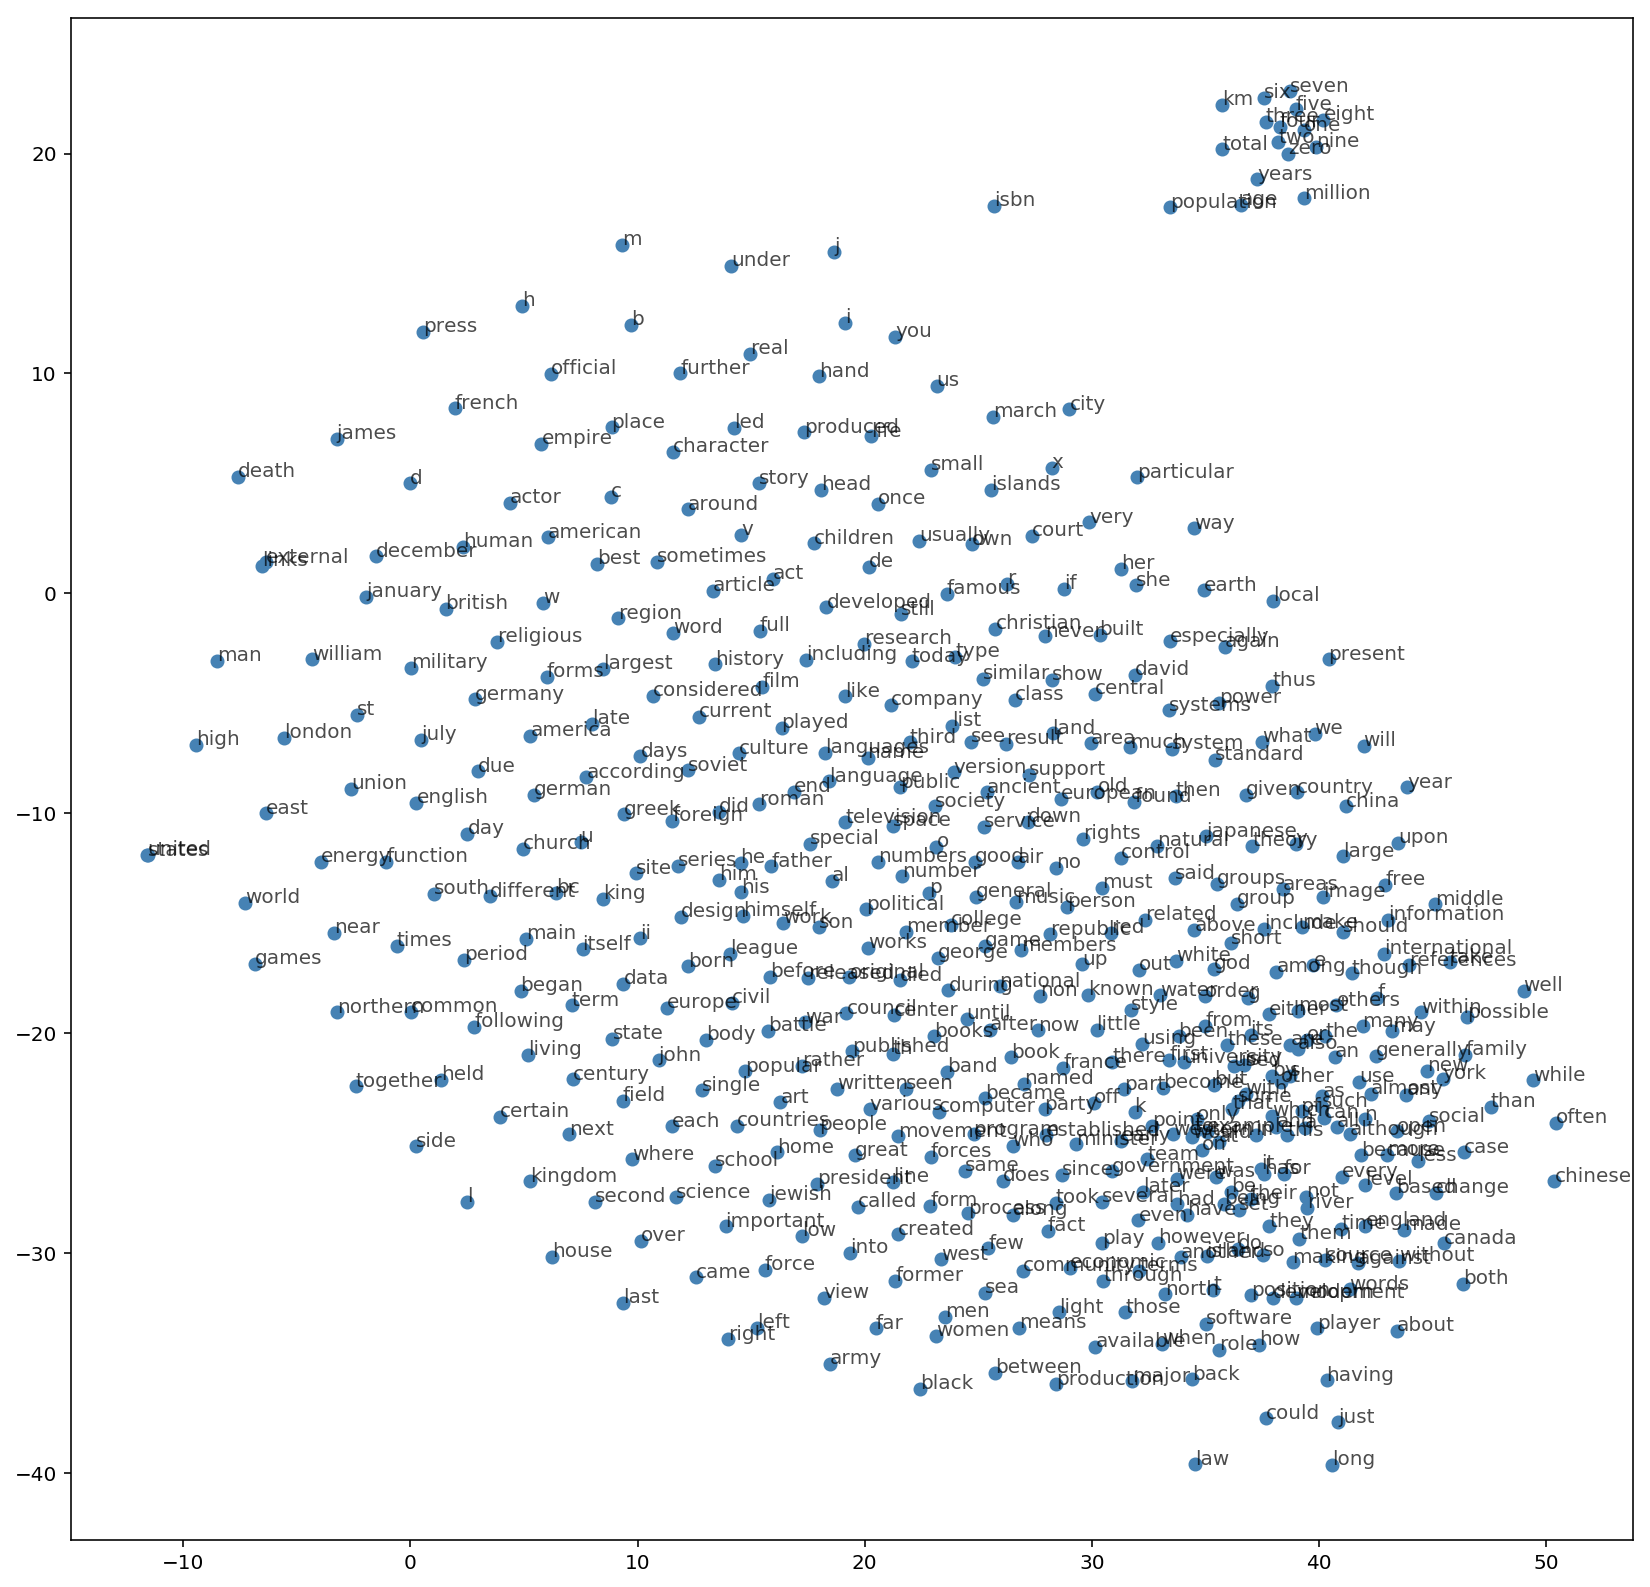

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)